In [1]:
from pyvizml import CreateNBAData
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
#player_stats = cnd.create_player_stats_df()
player_stats = pd.read_csv('player_stats.csv')
print(player_stats['pos'].dtype) # y 是一個離散的文字類別，面對的是分類器問題
print(player_stats['pos'].unique())
pos_dict = {
    0: 'G',
    1: 'F'
}
pos = player_stats['pos'].values
pos_binary = np.array([0 if p[0] == 'G' else 1 for p in pos])
print(np.unique(pos_binary))

object
['G' 'C' 'C-F' 'F-C' 'F' 'F-G' 'G-F']
[0 1]


In [3]:
X = player_stats[['apg', 'rpg']].values
y = pos_binary
X_train, X_valid, y_train, y_valid = train_test_split(X, y , test_size=0.33, random_state=42)
h = LogisticRegression(C=1e6) # C 很大, 正規化效果低; C 很小, 正規化效果高
h.fit(X_train, y_train) # ???
print(h.intercept_) # w_0
print(h.coef_)      # w_1 => apg, w_2 => rpg
p_hat = h.predict_proba(X_valid)
print(p_hat[:10])

[-1.72482393]
[[-1.89548986  1.60080397]]
[[0.52044208 0.47955792]
 [0.24779195 0.75220805]
 [0.60317353 0.39682647]
 [0.99403121 0.00596879]
 [0.43129753 0.56870247]
 [0.01419797 0.98580203]
 [0.83985411 0.16014589]
 [0.63692792 0.36307208]
 [0.0110132  0.9889868 ]
 [0.00437005 0.99562995]]


In [4]:
y_hat = h.predict(X_valid)
print(y_hat[:10])
y_hat = np.argmax(p_hat, axis=1)
print(y_hat[:10])

[0 1 0 0 1 1 0 0 1 1]
[0 1 0 0 1 1 0 0 1 1]


In [5]:
(y_hat != y_valid).sum() # 誤分類數

21

In [6]:
resolution = 50
apg = player_stats['apg'].values.astype(float)
rpg = player_stats['rpg'].values.astype(float)
X1 = np.linspace(apg.min() - 0.5, apg.max() + 0.5).reshape(-1, 1)
X2 = np.linspace(rpg.min() - 0.5, rpg.max() + 0.5).reshape(-1, 1)
APG, RPG = np.meshgrid(X1, X2)
print(APG.shape)
print(RPG.shape)

(50, 50)
(50, 50)


In [7]:
X_mock = np.array([10, 0]).reshape(1, -1)
print(X_mock)
p_hat_mock = h.predict_proba(X_mock) # p(y=0); p(y=1)
p_hat_mock[0, 1] # p(y=1)

[[10  0]]


1.044505216918743e-09

In [8]:
def plot_contour_filled(XX, YY, resolution=50):
    PROBA = np.zeros((resolution, resolution))
    for i in range(resolution):
        for j in range(resolution):
            xx_ij = XX[i, j]
            yy_ij = YY[i, j]
            X_plot = np.array([xx_ij, yy_ij]).reshape(1, -1)
            z = h.predict_proba(X_plot)[0, 1]
            PROBA[i, j] = z
    fig, ax = plt.subplots()
    CS = ax.contourf(XX, YY, PROBA, cmap='RdBu')
    ax.set_title("Probability of being predicted as a forward")
    ax.set_xlabel("Assists per game")
    ax.set_ylabel("Rebounds per game")
    fig.colorbar(CS, ax=ax)
    plt.show()

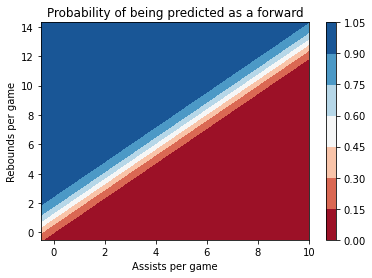

In [9]:
plot_contour_filled(APG, RPG)

In [10]:
def plot_contour_filled(XX, YY, x, y, resolution=50):
    PROBA = np.zeros((resolution, resolution))
    for i in range(resolution):
        for j in range(resolution):
            xx_ij = XX[i, j]
            yy_ij = YY[i, j]
            X_plot = np.array([xx_ij, yy_ij]).reshape(1, -1)
            z = h.predict_proba(X_plot)[0, 1]
            PROBA[i, j] = z
    fig, ax = plt.subplots()
    CS = ax.contourf(XX, YY, PROBA, cmap='RdBu')
    ax.set_title("Probability of being predicted as a forward")
    ax.set_xlabel("Assists per game")
    ax.set_ylabel("Rebounds per game")
    ax.scatter(x, y, color='yellow')
    fig.colorbar(CS, ax=ax)
    plt.show()

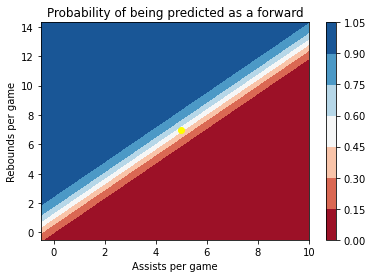

In [11]:
plot_contour_filled(APG, RPG, 5, 7)

In [12]:
def plot_decision_boundary(XX, YY, x, y, target_vector, pos_dict, h, resolution=50):
    Y_hat = np.zeros((resolution, resolution))
    for i in range(resolution):
        for j in range(resolution):
            xx_ij = XX[i, j]
            yy_ij = YY[i, j]
            X_plot = np.array([xx_ij, yy_ij]).reshape(1, -1)
            z = h.predict(X_plot)
            Y_hat[i, j] = z
    fig, ax = plt.subplots()
    CS = ax.contourf(XX, YY, Y_hat, alpha=0.2, cmap='RdBu')
    colors = ['red', 'blue']
    unique_categories = np.unique(target_vector)
    for color, i in zip(colors, unique_categories):
        xi = x[target_vector == i]
        yi = y[target_vector == i]
        ax.scatter(xi, yi, c=color, edgecolor='k', label="{}".format(pos_dict[i]), alpha=0.6)
    ax.set_title("Decision boundary of Forwards vs. Guards")
    ax.set_xlabel("Assists per game")
    ax.set_ylabel("Rebounds per game")
    ax.legend()
    plt.show()

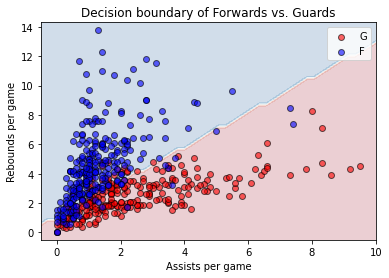

In [13]:
plot_decision_boundary(APG, RPG, apg, rpg, y, pos_dict, h)

In [14]:
def sigmoid(x):
    return(1 / (1 + np.exp(-x)))

In [15]:
def plot_sigmoid(lower_bound, upper_bound):
    x = np.linspace(lower_bound, upper_bound, 100)
    y = sigmoid(x)
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(x, y)
    ax.axvline(0, color = 'black')
    ax.axhline(y = 0, ls = ':', color = 'k', alpha = 0.5)
    ax.axhline(y = 0.5, ls = ':', color = 'k', alpha = 0.5)
    ax.axhline(y = 1, ls = ':', color = 'k', alpha = 0.5)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_ylim(-0.1, 1.1)
    ax.set_title("Sigmoid function")
    plt.show()

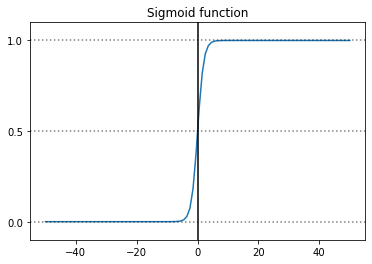

In [16]:
plot_sigmoid(-50, 50)

In [17]:
h.predict_proba(X_valid)[:10]

array([[0.52044208, 0.47955792],
       [0.24779195, 0.75220805],
       [0.60317353, 0.39682647],
       [0.99403121, 0.00596879],
       [0.43129753, 0.56870247],
       [0.01419797, 0.98580203],
       [0.83985411, 0.16014589],
       [0.63692792, 0.36307208],
       [0.0110132 , 0.9889868 ],
       [0.00437005, 0.99562995]])

In [18]:
h.intercept_

array([-1.72482393])

In [19]:
h.coef_

array([[-1.89548986,  1.60080397]])

In [20]:
w = np.array([
              h.intercept_[0], h.coef_[0, 0], h.coef_[0, 1]
]).reshape(3,)
w

array([-1.72482393, -1.89548986,  1.60080397])

In [21]:
X_0 = np.ones(X_valid.shape[0]).reshape(-1, 1)
X_valid_w_X0 = np.concatenate([X_0, X_valid], axis=1)
X_w = X_valid_w_X0.dot(w)
print(sigmoid(X_w)[:10])
print(1 - sigmoid(X_w)[:10])

[0.47955792 0.75220805 0.39682647 0.00596879 0.56870247 0.98580203
 0.16014589 0.36307208 0.9889868  0.99562995]
[0.52044208 0.24779195 0.60317353 0.99403121 0.43129753 0.01419797
 0.83985411 0.63692792 0.0110132  0.00437005]


In [22]:
print(p_hat[:10, 1])
print(p_hat[:10, 0])

[0.47955792 0.75220805 0.39682647 0.00596879 0.56870247 0.98580203
 0.16014589 0.36307208 0.9889868  0.99562995]
[0.52044208 0.24779195 0.60317353 0.99403121 0.43129753 0.01419797
 0.83985411 0.63692792 0.0110132  0.00437005]


In [23]:
def plot_cross_entropy():
    epsilon = 1e-5
    h = np.linspace(epsilon, 1-epsilon) # 利用微小值 epsilon 避免 log(0) 的錯誤
    y1 = -np.log(h)
    y2 = -np.log(1 - h)
    fig, ax = plt.subplots(1, 2, figsize = (8, 4))
    ax[0].plot(h, y1)
    ax[0].set_title("$y=1$\n$-\log(\sigma(Xw))$")
    ax[0].set_xticks([0, 1])
    ax[0].set_xticklabels([0, 1])
    ax[0].set_xlabel("$\sigma(Xw)$")
    ax[1].plot(h, y2)
    ax[1].set_title("$y=0$\n$-\log(1-\sigma(Xw))$")
    ax[1].set_xticks([0, 1])
    ax[1].set_xticklabels([0, 1])
    ax[1].set_xlabel("$\sigma(Xw)$")
    plt.tight_layout()
    plt.show()

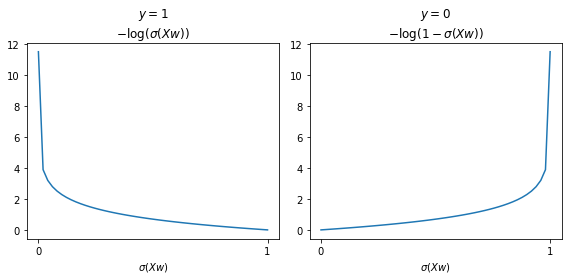

In [24]:
plot_cross_entropy()

In [25]:
class LogitReg:
    """
    This class defines the vanilla descent algorithm for logistic regression.
    Args:
        fit_intercept (bool): Whether to add intercept for this model.
    """
    def __init__(self, fit_intercept=True):
        self._fit_intercept = fit_intercept
    def sigmoid(self, X):
        """
        This function returns the Sigmoid output as a probability given certain model weights.
        """
        X_w = np.dot(X, self._w)
        p_hat = 1 / (1 + np.exp(-X_w))
        return p_hat
    def find_gradient(self):
        """
        This function returns the gradient given certain model weights.
        """
        m = self._m
        p_hat = self.sigmoid(self._X_train)
        X_train_T = np.transpose(self._X_train)
        gradient = (1/m) * np.dot(X_train_T, p_hat - self._y_train)
        return gradient
    def cross_entropy(self, epsilon=1e-06):
        """
        This function returns the cross entropy given certain model weights.
        """
        m = self._m
        p_hat = self.sigmoid(self._X_train)
        cost_y1 = -np.dot(self._y_train, np.log(p_hat + epsilon))
        cost_y0 = -np.dot(1 - self._y_train, np.log(1 - p_hat + epsilon))
        cross_entropy = (cost_y1 + cost_y0) / m
        return cross_entropy
    def fit(self, X_train, y_train, epochs=10000, learning_rate=0.001):
        """
        This function uses vanilla gradient descent to solve for weights of this model.
        Args:
            X_train (ndarray): 2d-array for feature matrix of training data.
            y_train (ndarray): 1d-array for target vector of training data.
            epochs (int): The number of iterations to update the model weights.
            learning_rate (float): The learning rate of gradient descent.
        """
        self._X_train = X_train.copy()
        self._y_train = y_train.copy()
        m = self._X_train.shape[0]
        self._m = m
        if self._fit_intercept:
            X0 = np.ones((self._m, 1), dtype=float)
            self._X_train = np.concatenate([X0, self._X_train], axis=1)
        n = self._X_train.shape[1]
        self._w = np.random.rand(n)
        n_prints = 10
        print_iter = epochs // n_prints
        for i in range(epochs):
            cross_entropy = self.cross_entropy()
            gradient = self.find_gradient()
            if i % print_iter == 0:
                print("epoch: {:6} - loss: {:.6f}".format(i, cross_entropy))
            self._w -= learning_rate*gradient
        w_ravel = self._w.ravel().copy()
        self.intercept_ = w_ravel[0]
        self.coef_ = w_ravel[1:].reshape(1, -1)
    def predict_proba(self, X_test):
        """
        This function returns predicted probability with weights of this model.
        Args:
            X_test (ndarray): 2d-array for feature matrix of test data.
        """
        m = X_test.shape[0]
        if self._fit_intercept:
            X0 = np.ones((m, 1), dtype=float)
            self._X_test = np.concatenate([X0, X_test], axis=1)
        p_hat_1 = self.sigmoid(self._X_test).reshape(-1, 1)
        p_hat_0 = 1 - p_hat_1
        proba = np.concatenate([p_hat_0, p_hat_1], axis=1)
        return proba
    def predict(self, X_test):
        """
        This function returns predicted label with weights of this model.
        Args:
            X_test (ndarray): 2d-array for feature matrix of test data.
        """
        proba = self.predict_proba(X_test)
        y_pred = np.argmax(proba, axis=1)
        return y_pred

In [26]:
lr = LogitReg()
lr.fit(X_train, y_train, epochs=30000, learning_rate=0.01)

epoch:      0 - loss: 1.795120
epoch:   3000 - loss: 0.352206
epoch:   6000 - loss: 0.339643
epoch:   9000 - loss: 0.336500
epoch:  12000 - loss: 0.335577
epoch:  15000 - loss: 0.335284
epoch:  18000 - loss: 0.335187
epoch:  21000 - loss: 0.335155
epoch:  24000 - loss: 0.335143
epoch:  27000 - loss: 0.335140


In [27]:
print(lr.intercept_)
print(lr.coef_)

-1.716794572026064
[[-1.89315215  1.59711001]]


In [28]:
print(h.intercept_)
print(h.coef_)

[-1.72482393]
[[-1.89548986  1.60080397]]


In [29]:
y_pred = lr.predict(X_valid)
print(y_pred[:10])

[0 1 0 0 1 1 0 0 1 1]


In [30]:
print(y_hat[:10])

[0 1 0 0 1 1 0 0 1 1]
